# DREAM5 Network Inference Challenge - Exploratory Data Analysis

## Overview

The DREAM5 (Dialogue on Reverse Engineering Assessment and Methods 5) Network Inference Challenge is a community-wide effort to benchmark gene regulatory network (GRN) inference methods. The challenge involved reconstructing transcriptional regulatory networks from gene expression microarray datasets for multiple organisms including E. coli, S. aureus, S. cerevisiae, and an in silico network.

## Dataset Structure

The DREAM5 dataset contains:

- **Training Data**: 4 networks (in silico, E. coli, S. aureus, S. cerevisiae) with gene expression data.
- **Test Data**: Gold standard networks for evaluation.
- **Original Data**: Raw experimental data for each organism.
- **Publication Data**: Research results and community predictions.
- **Scoring Methodology**: Evaluation scripts and protocols


## 1.0 Environment Configuration


In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

### 1.1 Environment Configuration


In [163]:
warnings.filterwarnings("ignore")

Plot styling


In [164]:
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")
pio.templates.default = "plotly_white"

Display options


In [165]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", 50)

## 2.0 Data Overview


In [166]:
@dataclass
class NetworkInfo:
    """
    Data class for storing network metadata
    """

    id: int
    name: str
    organism: str
    description: str

In [167]:
class DREAM5Explorer:
    """
    Design for analyzing DREAM5 Network inference data
    """

    def __init__(self, base_path: str = "/data/raw/dream5"):
        self.base_path = Path(base_path)
        self.networks = {
            1: NetworkInfo(
                1, "Network 1 - in silico", "In Silico", "Synthetic regulatory network"
            ),
            2: NetworkInfo(
                2, "Network 2 - S. aureus", "S. aureus", "Staphylococcus aureus"
            ),
            3: NetworkInfo(3, "Network 3 - E. coli", "E. coli", "Escherichia coli"),
            4: NetworkInfo(
                4,
                "Network 4 - S. cerevisiae",
                "S. cerevisiae",
                "Saccharomyces cerevisiae",
            ),
        }

        self.data_cache = {}

    def __repr__(self):
        return f"DREAM5Explorer(networks={len(self.networks)}, base_path='{self.base_path}')"

    def get_file_structure(self) -> Dict:
        """
        Analyze the complete file structure
        """

        structure = {}
        if not self.base_path.exists():
            return FileNotFoundError(f"Base path {self.base_path} does not exist")

        for net_id, net_info in self.networks.items():
            network_path = self.base_path / net_info.name
            if network_path.exists():
                files = list(network_path.glob("*.tsv"))
                structure[net_info.organism] = {
                    "path": str(network_path),
                    "files": [f.name for f in files],
                    "file_count": len(files),
                }

            else:
                structure[net_info.organism] = {"status": "not_found"}

        return structure

Initialize the explorer


In [168]:
BASE_PATH = "../data/raw/dream5/training data"

In [169]:
explorer = DREAM5Explorer(BASE_PATH)
file_structure = explorer.get_file_structure()

In [170]:
for organism, info in file_structure.items():
    if "status" not in info:
        print(f"\n{organism}")
        print(f"  Files: {info['file_count']}")

        for file in info["files"]:
            print(f" ├── {file}")

    else:
        print(f"\n{organism}: {info['status']}")


In Silico
  Files: 5
 ├── SYNAPSE_METADATA_MANIFEST.tsv
 ├── net1_transcription_factors.tsv
 ├── net1_chip_features.tsv
 ├── net1_expression_data.tsv
 ├── net1_gene_ids.tsv

S. aureus
  Files: 5
 ├── SYNAPSE_METADATA_MANIFEST.tsv
 ├── net2_transcription_factors.tsv
 ├── net2_expression_data.tsv
 ├── net2_gene_ids.tsv
 ├── net2_chip_features.tsv

E. coli
  Files: 5
 ├── SYNAPSE_METADATA_MANIFEST.tsv
 ├── net3_chip_features.tsv
 ├── net3_transcription_factors.tsv
 ├── net3_gene_ids.tsv
 ├── net3_expression_data.tsv

S. cerevisiae
  Files: 5
 ├── net4_expression_data.tsv
 ├── SYNAPSE_METADATA_MANIFEST.tsv
 ├── net4_chip_features.tsv
 ├── net4_transcription_factors.tsv
 ├── net4_gene_ids.tsv


## 3.0 Dataset Structure Analysis


In [171]:
def load_network_data(network_id: int) -> Dict[str, pd.DataFrame]:
    """
    Load all data files for a specific network

    Args:
      network_id (int): Network identifier (1 to 4)

    Returns:
      Dict[str, pd.DataFrame]: Dictionary containing loaded dataframes
    """

    network_info = explorer.networks[network_id]
    network_path = explorer.base_path / network_info.name

    data = {}
    file_types = [
        "chip_features",
        "expression_data",
        "gene_ids",
        "transcription_factors",
    ]

    print(f"Loading {network_info.organism} data")
    for file_type in file_types:
        file_path = network_path / f"net{network_id}_{file_type}.tsv"

        try:
            if file_type == "transcription_factors":
                df = pd.read_csv(file_path, header=None, names=["gene_id"])

            else:
                df = pd.read_csv(file_path, sep="\t")
                print(f"{file_type}: {df.shape[0]} rows x {df.shape[1]} cols")

            data[file_type] = df

        except FileNotFoundError:
            print(f"{file_type}: File not found")

        except Exception as e:
            print(f"{file_type}: Error loading {str(e)}")

    return data

In [172]:
net1_data = load_network_data(1)

Loading In Silico data
chip_features: 805 rows x 8 cols
expression_data: 805 rows x 1643 cols
gene_ids: 1643 rows x 2 cols


### 3.1 🧬 Network 1 (In Silico) Deep Dive


In [173]:
def analyze_gene_information(gene_data: pd.DataFrame, tf_data: pd.DataFrame) -> Dict:
    """
    Gene and transcription factor analysis

    Args:
      gene_data (pd.DataFrame): Gene ID mappings
      tf_data (pd.DataFrame): Transcription factor list

    Reurns:
      Dictionary with analysis results
    """

    total_genes = len(gene_data)
    total_tfs = len(tf_data)
    tf_percentage = (total_tfs / total_genes) * 100

    # Analyze name patterns
    gene_names = gene_data["Name"].str.lower()
    categories = {
        "regulators": gene_names.str.contains("r$|regulator|repressor", na=False).sum(),
        "enzymes": gene_names.str.contains("ase$|synthase|reductase", na=False).sum(),
        "transporters": gene_names.str.contains("transport|permease", na=False).sum(),
        "decoys": gene_names.str.contains("decoy", na=False).sum(),
    }

    results = {
        "total_genes": total_genes,
        "total_tfs": total_tfs,
        "tf_percentage": tf_percentage,
        "categories": categories,
        "tf_genes": set(tf_data["gene_id"].tolist()),
        "sample_genes": gene_data.head(10).to_dict("records"),
    }

    return results

In [174]:
if "gene_ids" in net1_data and "transcription_factors" in net1_data:
    gene_analysis = analyze_gene_information(
        net1_data["gene_ids"], net1_data["transcription_factors"]
    )

    print("Gene Information Analysis")
    print(f"📊 Total genes: {gene_analysis['total_genes']:,}")
    print(f"🎯 Transcription factors: {gene_analysis['total_tfs']:,}")
    print(f"📈 TF percentage: {gene_analysis['tf_percentage']:.1f}%")

    print(f"\nGene Categories: ")
    for category, count in gene_analysis["categories"].items():
        percentage = (count / gene_analysis["total_genes"]) * 100
        print(f"   {category.title()}: {count:,} ({percentage:.1f}%)")

    print(f"\nSample Gene Mapping")
    for gene in gene_analysis["sample_genes"]:
        tf_status = "🎯" if gene["#ID"] in gene_analysis["tf_genes"] else "  "
        print(f"   {tf_status} {gene['#ID']}: {gene['Name']}")

Gene Information Analysis
📊 Total genes: 1,643
🎯 Transcription factors: 195
📈 TF percentage: 11.9%

Gene Categories: 
   Regulators: 112 (6.8%)
   Enzymes: 0 (0.0%)
   Transporters: 0 (0.0%)
   Decoys: 78 (4.7%)

Sample Gene Mapping
   🎯 G1: tyrR
   🎯 G2: glpR
   🎯 G3: tdcA
   🎯 G4: allS
   🎯 G5: mtlR
   🎯 G6: treR
   🎯 G7: adiY
   🎯 G8: cysB
   🎯 G9: decoy15
   🎯 G10: hcaR


### 3.2 Experimental Design Analysis


In [175]:
def analyze_experimental_design(chip_data: pd.DataFrame) -> Dict:
    """
    Comprehensive experimental design analysis

    Args:
      chip_data (pd.DataFrame): Chip features dataframe

    Returns:
        Dictionary with experimental statistics
    """

    total_experiments = chip_data["#Experiment"].nunique()
    total_samples = len(chip_data)

    # Replicate analysis
    replicate_stats = chip_data.groupby("#Experiment")["Repeat"].max()
    conditions = {
        "control": chip_data["Perturbations"].isna().sum(),
        "perturbation": chip_data["Perturbations"].notna().sum(),
        "time_course": chip_data["Time"].notna().sum(),
        "gene_deletion": chip_data["DeletedGenes"].notna().sum(),
        "gene_overexpression": chip_data["OverexpressedGenes"].notna().sum(),
    }

    # Time analysis
    time_points = chip_data["Time"].dropna()
    time_stats = {
        "count": len(time_points),
        "min": time_points.min() if len(time_points) > 0 else None,
        "max": time_points.max() if len(time_points) > 0 else None,
        "unique_timepoints": time_points.nunique(),
    }

    # Perturbation analysis
    perturbations = chip_data["Perturbations"].dropna()
    pert_stats = {
        "count": len(perturbations),
        "unique": perturbations.nunique(),
        "top_perturbations": perturbations.value_counts().head().to_dict(),
    }

    pert_levels = chip_data["PerturbationLevels"].dropna()
    level_stats = {
        "count": len(pert_levels),
        "unique": pert_levels.nunique(),
        "distribution": pert_levels.value_counts().sort_index().to_dict(),
    }

    return {
        "basic_stats": {
            "total_experiments": total_experiments,
            "total_samples": total_samples,
            "avg_replicates": replicate_stats.mean(),
            "replicate_range": (replicate_stats.min(), replicate_stats.max()),
        },
        "conditions": conditions,
        "time_course": time_stats,
        "perturbations": pert_stats,
        "perturbation_levels": level_stats,
    }

In [176]:
if "chip_features" in net1_data:
    exp_analysis = analyze_experimental_design(net1_data["chip_features"])
    stats = exp_analysis["basic_stats"]

    print(f"🔬 Total experiments: {stats['total_experiments']:,}")
    print(f"📊 Total samples: {stats['total_samples']:,}")
    print(f"🔄 Average replicates: {stats['avg_replicates']:.1f}")
    print(
        f"📏 Replicate range: {stats['replicate_range'][0]}-{stats['replicate_range'][1]}"
    )

    print(f"\n🎛️  Experimental Conditions:")
    for condition, count in exp_analysis["conditions"].items():
        percentage = (count / stats["total_samples"]) * 100
        print(
            f"   {condition.replace('_', ' ').title()}: {count:,} ({percentage:.1f}%)"
        )

    time_stats = exp_analysis["time_course"]
    if time_stats["count"] > 0:
        print(f"\n⏰ Time Course Analysis:")
        print(f"   Samples: {time_stats['count']:,}")
        print(f"   Time range: {time_stats['min']:.0f} - {time_stats['max']:.0f} hours")
        print(f"   Unique timepoints: {time_stats['unique_timepoints']}")

    pert_stats = exp_analysis["perturbations"]
    if pert_stats["count"] > 0:
        print(f"\n🎯 Perturbation Analysis:")
        print(f"   Total perturbation samples: {pert_stats['count']:,}")
        print(f"   Unique perturbations: {pert_stats['unique']}")
        print(f"   Top perturbations:")

        for pert, count in list(pert_stats["top_perturbations"].items())[:5]:
            print(f"      {pert}: {count} samples")

🔬 Total experiments: 107
📊 Total samples: 805
🔄 Average replicates: 2.0
📏 Replicate range: 1-5

🎛️  Experimental Conditions:
   Control: 460 (57.1%)
   Perturbation: 345 (42.9%)
   Time Course: 463 (57.5%)
   Gene Deletion: 186 (23.1%)
   Gene Overexpression: 17 (2.1%)

⏰ Time Course Analysis:
   Samples: 463
   Time range: 0 - 520 hours
   Unique timepoints: 37

🎯 Perturbation Analysis:
   Total perturbation samples: 345
   Unique perturbations: 43
   Top perturbations:
      P12: 52 samples
      P2: 32 samples
      P11: 26 samples
      P13: 20 samples
      P20,P19: 13 samples


### 3.3 Data Quality Assessment


In [177]:
def assess_data_quality(data_dict: Dict[str, pd.DataFrame]) -> Dict:
    """
    Comprehensive data quality assessment

    Args:
      data_dict (Dict[str, pd.DataFrame]): Dictionary of loaded dataframes

    Returns:
      Dict with Quality Assessment Results
    """

    quality_report = {}
    for data_type, df in data_dict.items():
        if df is None or df.empty:
            continue

        metrics = {
            "shape": df.shape,
            "memory_usage_mb": df.memory_usage(deep=True).sum() / 1024 / 1024,
            "missing_values": df.isnull().sum().sum(),
            "missing_percentage": (df.isnull().sum().sum() / df.size) * 100,
            "duplicate_rows": df.duplicated().sum(),
        }

        column_info = {}
        for col in df.columns:
            col_data = df[col]
            column_info[col] = {
                "dtype": str(col_data.dtype),
                "unique_values": col_data.nunique(),
                "missing_count": col_data.isnull().sum(),
                "missing_percentage": (col_data.isnull().sum() / len(col_data)) * 100,
            }

            if pd.api.types.is_numeric_dtype(col_data):
                column_info[col]["value_range"] = (col_data.min(), col_data.max())

        quality_report[data_type] = {"metrics": metrics, "columns": column_info}

    return quality_report

In [178]:
quality_assessment = assess_data_quality(net1_data)

In [179]:
for data_type, assessment in quality_assessment.items():
    metrics = assessment["metrics"]
    print(f"\n📋 {data_type.replace('_', ' ').title()}")
    print(f"   Shape: {metrics['shape'][0]:,} rows × {metrics['shape'][1]} columns")
    print(f"   Memory usage: {metrics['memory_usage_mb']:.2f} MB")
    print(
        f"   Missing values: {metrics['missing_values']:,} ({metrics['missing_percentage']:.2f}%)"
    )
    print(f"   Duplicate rows: {metrics['duplicate_rows']:,}")


📋 Chip Features
   Shape: 805 rows × 8 columns
   Memory usage: 0.14 MB
   Missing values: 3,663 (56.88%)
   Duplicate rows: 1

📋 Expression Data
   Shape: 805 rows × 1643 columns
   Memory usage: 10.09 MB
   Missing values: 0 (0.00%)
   Duplicate rows: 0

📋 Gene Ids
   Shape: 1,643 rows × 2 columns
   Memory usage: 0.19 MB
   Missing values: 0 (0.00%)
   Duplicate rows: 0

📋 Transcription Factors
   Shape: 195 rows × 1 columns
   Memory usage: 0.01 MB
   Missing values: 0 (0.00%)
   Duplicate rows: 0


In [180]:
missing_cols = {
    col: info
    for col, info in assessment["columns"].items()
    if info["missing_count"] > 0
}

if missing_cols:
    print(f"   Columns with missing data:")
    for col, info in missing_cols.items():
        print(
            f"      {col}: {info['missing_count']:,} ({info['missing_percentage']:.1f}%)"
        )

### 3.4 Visualizations


In [183]:
def create_visualizations(
    chip_data: pd.DataFrame, gene_data: pd.DataFrame, tf_data: pd.DataFrame
):
    """
    Create visualizations
    """

    fig = plt.figure(figsize=(25, 30))
    gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

    # 1. Experiment distribution (pie chart)
    ax1 = fig.add_subplot(gs[0, 0])
    exp_types = []

    for _, row in chip_data.iterrows():
        if pd.notna(row.get("Perturbations")):
            exp_types.append("Chemical\nPerturbations")

        elif pd.notna(row.get("DeletedGenes")):
            exp_types.append("Gene\nDeletion")

        elif pd.notna(row.get("Time")):
            exp_types.append("Time\nCourse")

        else:
            exp_types.append("Control")

    exp_counts = pd.Series(exp_types).value_counts()
    colors = plt.cm.Set3(np.linspace(0, 1, len(exp_counts)))

    wedges, texts, autotexts = ax1.pie(
        exp_counts.values,
        labels=exp_counts.index,
        autopct="%1.1f%%",
        colors=colors,
        startangle=90,
    )
    ax1.set_title(
        "Experiment Type Distribution", fontsize=14, fontweight="bold", pad=20
    )

    # 2. Replicate distribution
    ax2 = fig.add_subplot(gs[0, 1])
    rep_counts = (
        chip_data.groupby("#Experiment")["Repeat"].max().value_counts().sort_index()
    )

    bars = ax2.bar(
        rep_counts.index,
        rep_counts.values,
        alpha=0.7,
        color="skyblue",
        edgecolor="navy",
    )
    ax2.set_xlabel("Number of Replicates")
    ax2.set_ylabel("Number of Experiments")
    ax2.set_title("Biological Replicate Distribution", fontweight="bold")
    ax2.grid(axis="y", alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        ax2.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.5,
            f"{int(height)}",
            ha="center",
            va="bottom",
            fontsize=10,
        )

    # 3. Time course analysis
    ax3 = fig.add_subplot(gs[0, 2])
    time_data = chip_data["Time"].dropna()

    if len(time_data) > 0:
        ax3.hist(time_data, bins=25, alpha=0.7, color="lightcoral", edgecolor="darkred")

        ax3.set_xlabel("Time (hours)")
        ax3.set_ylabel("Number of Samples")
        ax3.set_title("Time Course Distribution", fontweight="bold")
        ax3.grid(axis="y", alpha=0.3)
        ax3.text(
            0.7,
            0.8,
            f"Samples: {len(time_data)}\nRange: {time_data.min():.0f}-{time_data.max():.0f}h\nMedian: {time_data.median():.0f}h",
            transform=ax3.transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
        )

    # 4. Perturbation levels
    ax4 = fig.add_subplot(gs[1, 0])
    pert_levels = chip_data["PerturbationLevels"].dropna()

    if len(pert_levels) > 0:
        level_counts = pert_levels.value_counts().sort_index()
        bars = ax4.bar(
            range(len(level_counts)),
            level_counts.values,
            alpha=0.7,
            color="lightgreen",
            edgecolor="darkgreen",
        )
        ax4.set_xticks(range(len(level_counts)))
        ax4.set_xticklabels(
            [
                f"{float(x):.2f}" if isinstance(x, (int, float)) else str(x)
                for x in level_counts.index
            ],
            rotation=45,
            ha="right",
        )
        ax4.set_xlabel("Perturbation Level")
        ax4.set_ylabel("Number of Samples")
        ax4.set_title("Perturbation Level Distribution", fontweight="bold")
        ax4.grid(axis="y", alpha=0.3)

    # 5. Top Perturbations
    ax5 = fig.add_subplot(gs[1, 1:])
    perturbations = chip_data["Perturbations"].dropna()

    if len(perturbations) > 0:
        top_perts = perturbations.value_counts().head(10)
        bars = ax5.barh(
            range(len(top_perts)), top_perts.values, alpha=0.7, color="orange"
        )

        ax5.set_yticks(range(len(top_perts)))
        ax5.set_yticklabels(top_perts.index)
        ax5.set_xlabel("Number of Samples")
        ax5.set_title("Top 10 Perturbations by Frequency", fontweight="bold")
        ax5.grid(axis="x", alpha=0.3)

        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax5.text(
                width + 0.5,
                bar.get_y() + bar.get_height() / 2,
                f"{int(width)}",
                ha="left",
                va="center",
                fontsize=9,
            )

    # 6. Gene categories analysis
    ax6 = fig.add_subplot(gs[2, :2])
    gene_names = gene_data["Name"].str.lower()
    categories = {
        "Regulators": gene_names.str.contains("r$|regulator|repressor", na=False).sum(),
        "Enzymes": gene_names.str.contains("ase$|synthase|reductase", na=False).sum(),
        "Transporters": gene_names.str.contains("transport|permease", na=False).sum(),
        "Decoys": gene_names.str.contains("decoy", na=False).sum(),
        "Others": len(gene_data)
        - gene_names.str.contains(
            "r$|regulator|repressor|ase$|synthase|reductase|transport|permease|decoy",
            na=False,
        ).sum(),
    }

    cat_series = pd.Series(categories)
    bars = ax6.bar(
        cat_series.index,
        cat_series.values,
        alpha=0.7,
        color=["#FF9999", "#66B2FF", "#99FF99", "#FFCC99", "#FF99CC"],
    )

    ax6.set_ylabel("Number of Genes")
    ax6.set_title("Gene Categories Distribution", fontweight="bold")
    ax6.grid(axis="y", alpha=0.3)

    total_genes = len(gene_data)
    for bar, count in zip(bars, cat_series.values):
        height = bar.get_height()
        percentage = (count / total_genes) * 100
        ax6.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + total_genes * 0.01,
            f"{count}\n({percentage:.1f}%)",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    plt.tight_layout()
    plt.show()

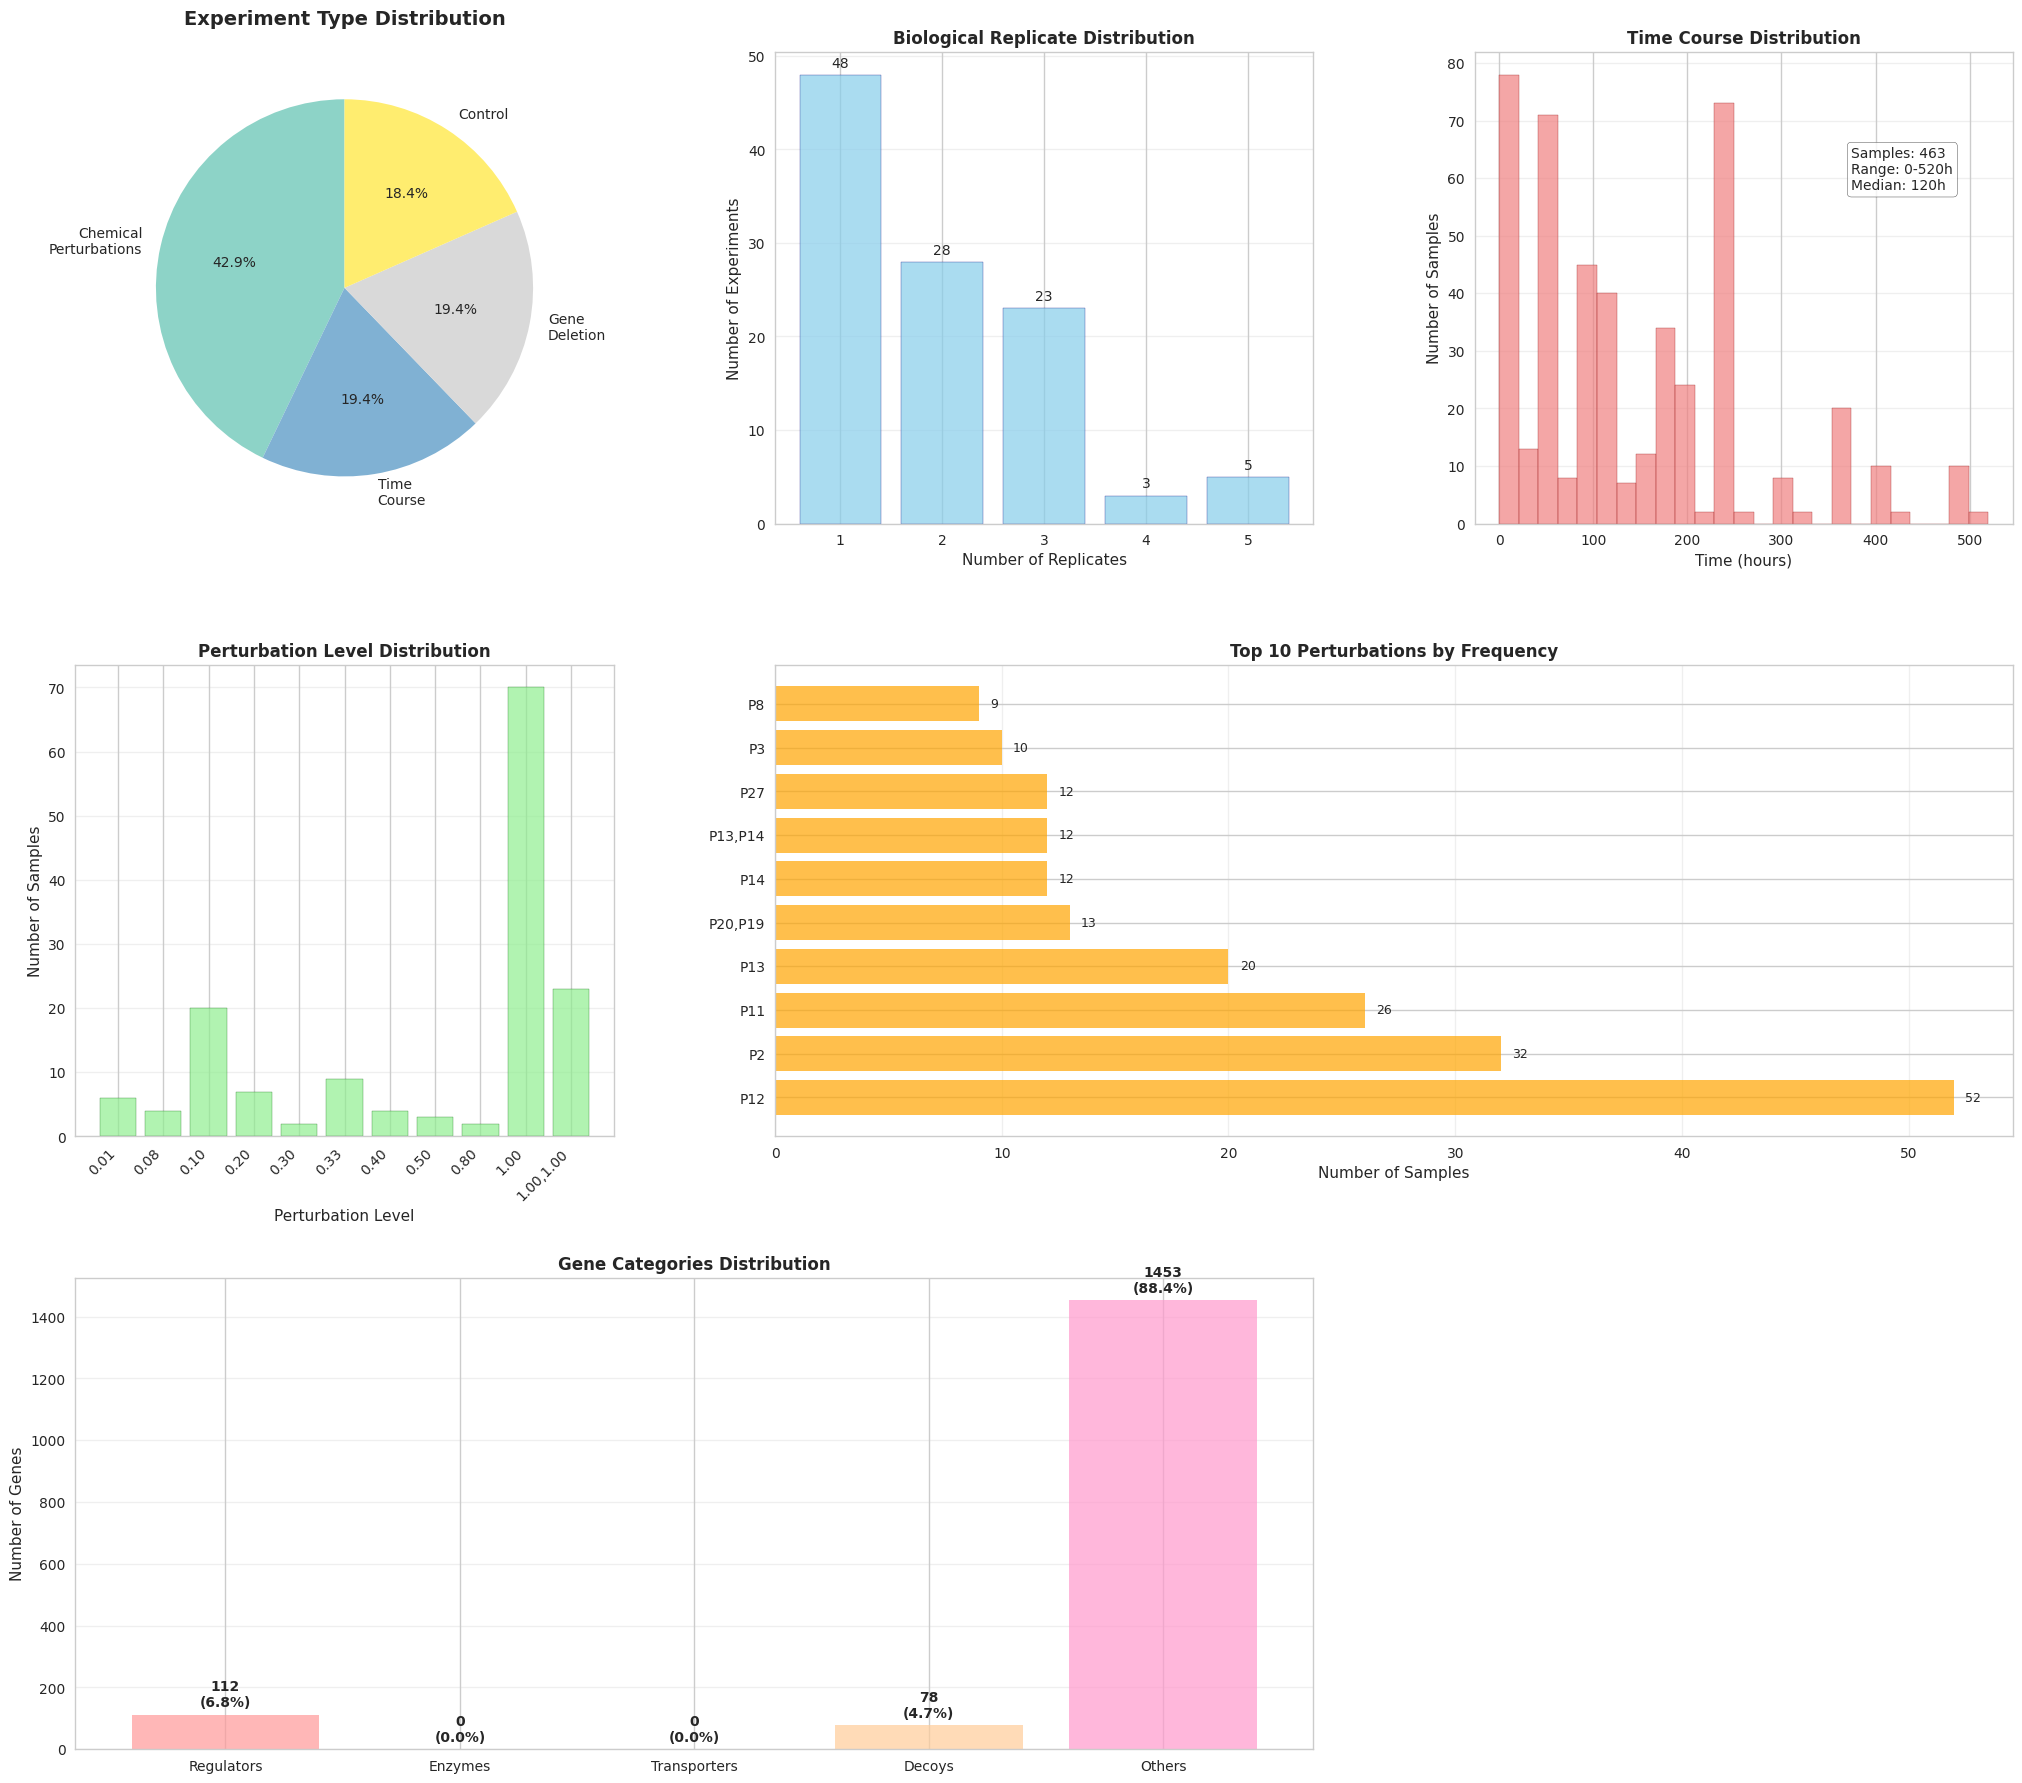

In [184]:
if all(
    key in net1_data for key in ["chip_features", "gene_ids", "transcription_factors"]
):
    viz_fig = create_visualizations(
        net1_data["chip_features"],
        net1_data["gene_ids"],
        net1_data["transcription_factors"],
    )